In [31]:
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import numpy as np

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


callback function

In [80]:
def callback_(filepath, monitor="val_loss", tensorboard=True, earlystop):
    callback_list = []

    callback_list.append(keras.callbacks.ModelCheckpoint(filepath,
                                                         save_best_only = True,
                                                         monitor=monitor
                                                         ))
    if tensorboard:
        log_dir = "tensorlog_" + filepath
        callback_list.append(keras.callbacks.TensorBoard(log_dir=log_dir))

    if earlystop>0:
        callback_list.append(keras.callbacks.EarlyStopping(patience=earlystop))

    return callback_list

Let's get and classify data first

In [81]:
data_dir = '/content/drive/MyDrive/colab/cat_dog_classification_using_CNN/cat_dog'

train_path = data_dir + "/train"
test_path = data_dir + "/test"
validation_path = data_dir + "/validation"

Visualise the original data

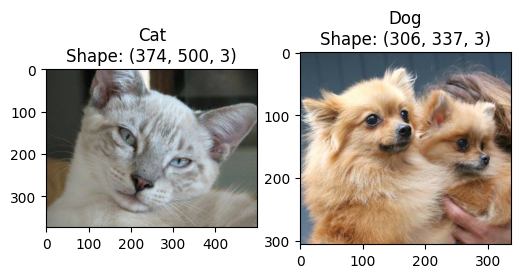

In [82]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

cat_image = train_path + '/cat/cat.69.jpg'
dog_image = train_path + '/dog/dog.77.jpg'

cat_img = imread(cat_image)
dog_img = imread(dog_image)

# Prepare list of (image array, title)
imgs = [
    (cat_img, f"Cat\nShape: {cat_img.shape}"),
    (dog_img, f"Dog\nShape: {dog_img.shape}")
]

plt.figure(figsize=(6,3))
for i, (img, title) in enumerate(imgs, 1):
    plt.subplot(1, 2, i)
    plt.imshow(img)
    plt.title(title)
plt.show()



So from above images it's quite clear that all the images have different dimensions. So plot the variations in dimension

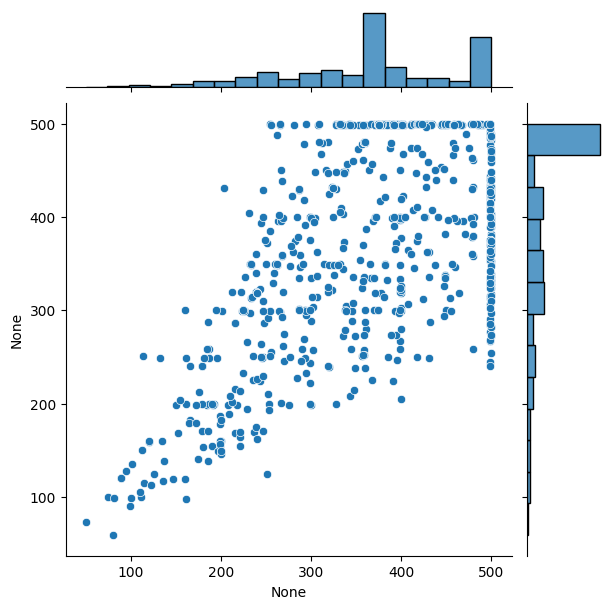

In [83]:
height = []
width = []

for image_file in os.listdir(train_path+'/dog'):
    image  = imread(train_path +'/dog/' + image_file)
    h,w,c = image.shape
    height.append(h)
    width.append(w)

sns.jointplot(x=height,y=width)

Now, we just have the images in folders. We need to make it into a workable dataset:
  * which has labels
  * all the images have the same size

In [84]:
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
                train_path,
                image_size=(180,180),
                batch_size=32
)
validation_dataset = image_dataset_from_directory(
                validation_path,
                image_size=(180,180),
                batch_size=32
)
test_dataset = image_dataset_from_directory(
                test_path,
                image_size=(180,180),
                batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1012 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Verify batch size

In [87]:
for data_batch,labels_batch in train_dataset:
    print(f"image batch shape:{data_batch.shape}")
    print(f"label batch shape:{labels_batch.shape}")
    break


image batch shape:(32, 180, 180, 3)
label batch shape:(32,)


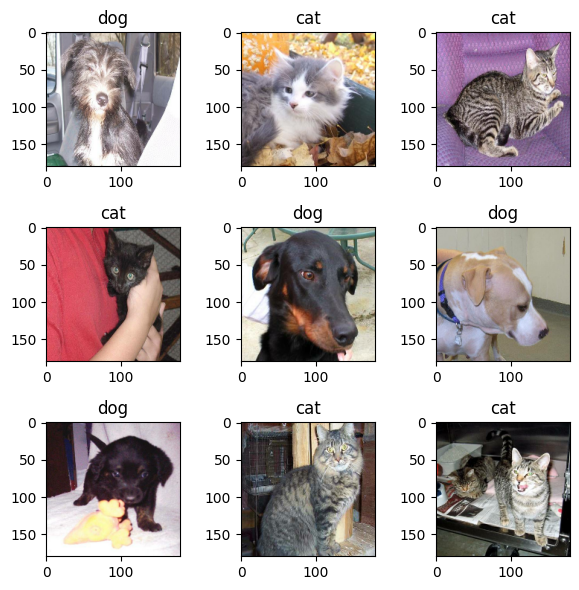

In [88]:
images = data_batch.numpy()
labels = labels_batch.numpy()

plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].astype("uint8"))  # convert float -> int for display
    plt.title("cat" if labels[i] == 0 else "dog")
plt.tight_layout()
plt.show()


Defining convet model

In [89]:
from keras import Input
from keras.layers import Rescaling,Conv2D,MaxPooling2D,Flatten,Dense

input = Input(shape=(180,180,3))
rescaling =  Rescaling(1./255,name="Rescaling")(input)
conv1 = Conv2D(filters=32, kernel_size=3,activation='relu',name= "Conv1")(rescaling)
maxpool1 = MaxPooling2D(pool_size=2, name = "Pool1")(conv1)
conv2 = Conv2D(filters=64, kernel_size=3,activation='relu',name= "Conv2")(maxpool1)
maxpool2 = MaxPooling2D(pool_size=2, name = "Pool2")(conv2)
conv3 = Conv2D(filters=128, kernel_size=3,activation='relu',name= "Conv3")(maxpool2)
maxpool3 = MaxPooling2D(pool_size=2, name = "Pool3")(conv3)
conv4 = Conv2D(filters=256, kernel_size=3,activation='relu',name= "Conv4")(maxpool3)
maxpool4 = MaxPooling2D(pool_size=2, name = "Pool4")(conv4)
conv5 = Conv2D(filters=256, kernel_size=3,activation='relu',name= "Conv5")(maxpool4)
flatten = Flatten(name="Flatten")(conv5)
output = Dense(1, activation=tf.nn.sigmoid)(flatten)

model = keras.Model(inputs= input, outputs = output)


In [73]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool4 (MaxPooling2D)            │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

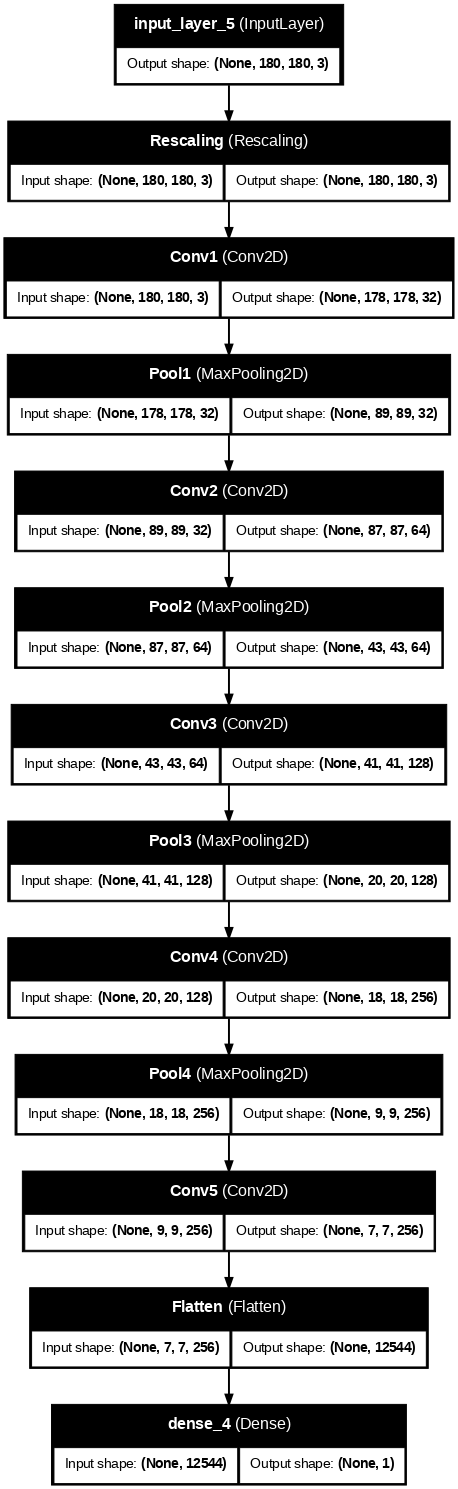

In [74]:
from keras.utils import plot_model
plot_model(model, dpi = 70, show_shapes=True,show_layer_names=True)

In [75]:
model.compile(loss='binary_crossentropy',
                    optimizer = 'Adam',
                    metrics = ['Accuracy'])

In [44]:
history = model.fit(
            train_dataset,
            epochs = 20,
            validation_data = validation_dataset,
            callbacks = callback_("cnn.keras",earlystop=3)
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 310ms/step - Accuracy: 0.4969 - loss: 0.6961 - val_Accuracy: 0.5059 - val_loss: 0.6926
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - Accuracy: 0.5253 - loss: 0.6909 - val_Accuracy: 0.5939 - val_loss: 0.6678
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - Accuracy: 0.5902 - loss: 0.6694 - val_Accuracy: 0.6285 - val_loss: 0.6251
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - Accuracy: 0.6310 - loss: 0.6449 - val_Accuracy: 0.5741 - val_loss: 0.6970
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - Accuracy: 0.6416 - loss: 0.6238 - val_Accuracy: 0.6897 - val_loss: 0.5832
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - Accuracy: 0.6906 - loss: 0.5754 - val_Accuracy: 0.6976 - val_loss: 0.5688
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - Accuracy: 0.7055 - loss: 0.5570 - val_Accuracy: 0.6749 - val_loss: 0.6055
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - Accuracy: 0.7191 - loss: 0.5290 - val_Accur

In [45]:
test_model = keras.models.load_model("cnn.keras")

In [52]:
test_loss,test_acc = model.evaluate(test_dataset)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - Accuracy: 0.7410 - loss: 0.6480


In [110]:
class_names = test_dataset.class_names  # ['cat', 'dog']

for images, labels in test_dataset.take(1):
    sample_images = images[:9]
    sample_labels = labels[:9]


From just **2000** images, our network has learnt to classify images of cats and dogs with an accuracy of apx **70%**

In [111]:
predictions = model.predict(sample_images)
predicted_classes = tf.argmax(predictions, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


In [112]:
predicted_classes = (predictions > 0.5).astype("int32").flatten()

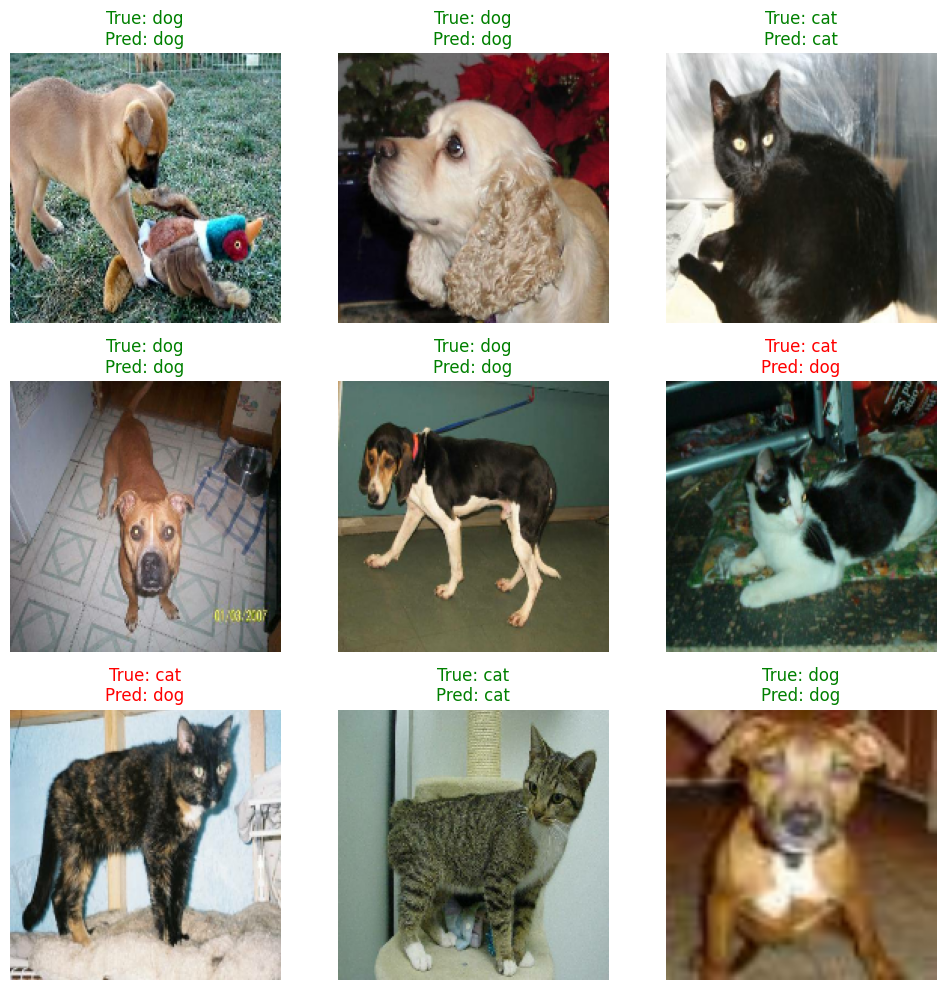

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    true_label = class_names[sample_labels[i]]
    pred_label = class_names[predicted_classes[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()

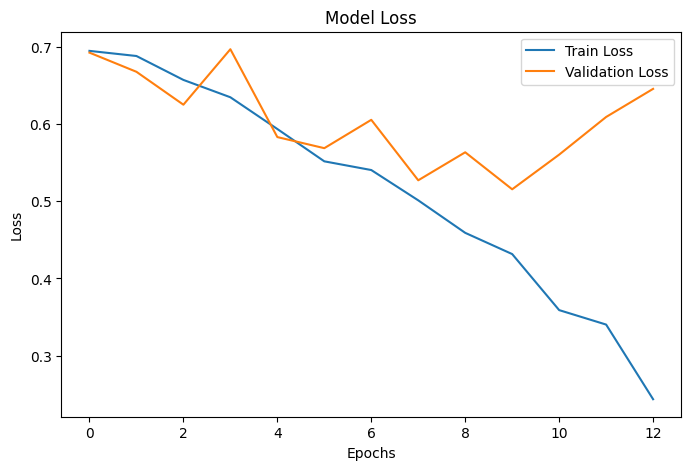

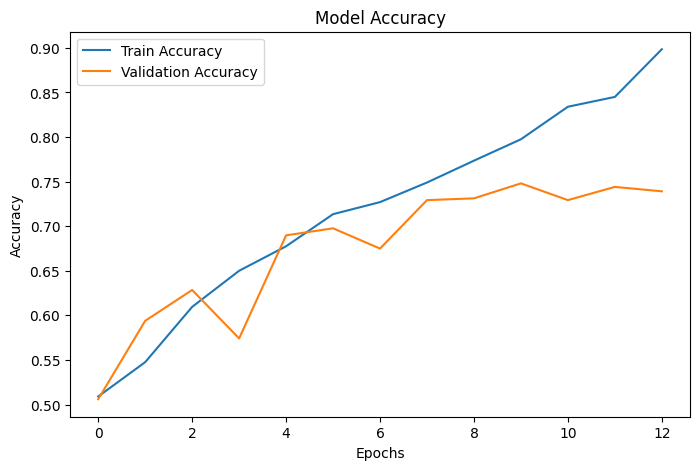

In [58]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy Graph
plt.figure(figsize=(8,5))
plt.plot(history.history['Accuracy'], label='Train Accuracy')
plt.plot(history.history['val_Accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [90]:
def get_data_augmented(flip='horizontal', rotation=0.1, zoom=0.2):
    data_augmentation = keras.Sequential([
        keras.layers.RandomFlip(flip),
        keras.layers.RandomRotation(rotation),
        keras.layers.RandomZoom(zoom)
    ])
    return data_augmentation

augment_data = get_data_augmented()

In [91]:
input = Input(shape=(180,180,3))

data_augmentation = augment_data(input)
rescaling =  Rescaling(1./255,name="Rescaling")(data_augmentation)
conv1 = Conv2D(filters=32, kernel_size=3,activation='relu',name= "Conv1")(rescaling)
maxpool1 = MaxPooling2D(pool_size=2, name = "Pool1")(conv1)
conv2 = Conv2D(filters=64, kernel_size=3,activation='relu',name= "Conv2")(maxpool1)
maxpool2 = MaxPooling2D(pool_size=2, name = "Pool2")(conv2)
conv3 = Conv2D(filters=128, kernel_size=3,activation='relu',name= "Conv3")(maxpool2)
maxpool3 = MaxPooling2D(pool_size=2, name = "Pool3")(conv3)
conv4 = Conv2D(filters=256, kernel_size=3,activation='relu',name= "Conv4")(maxpool3)
maxpool4 = MaxPooling2D(pool_size=2, name = "Pool4")(conv4)
conv5 = Conv2D(filters=256, kernel_size=3,activation='relu',name= "Conv5")(maxpool4)
flatten = Flatten(name="Flatten")(conv5)
output = Dense(1, activation=tf.nn.sigmoid)(flatten)

model = keras.Model(inputs= input, outputs = output)


In [92]:
model.compile(loss='binary_crossentropy',
                        optimizer='Adam',
                        metrics=['Accuracy'])

In [93]:
history = model.fit(train_dataset,
                    epochs=80,
                    validation_data = validation_dataset,
                    callbacks=callback_("cnn.keras",earlystop=15))

Epoch 1/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - Accuracy: 0.5120 - loss: 0.6948 - val_Accuracy: 0.4941 - val_loss: 0.6933
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - Accuracy: 0.5240 - loss: 0.6925 - val_Accuracy: 0.5346 - val_loss: 0.6843
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - Accuracy: 0.5627 - loss: 0.6858 - val_Accuracy: 0.6275 - val_loss: 0.6612
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - Accuracy: 0.5855 - loss: 0.6679 - val_Accuracy: 0.5810 - val_loss: 0.6756
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - Accuracy: 0.6259 - loss: 0.6498 - val_Accuracy: 0.6186 - val_loss: 0.6968
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - Accuracy: 0.6145 - loss: 0.6601 - val_Accuracy: 0.6008 - val_loss: 0.6441
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - Accuracy: 0.6473 - loss: 0.6210 - val_Accuracy: 0.6324 - val_loss: 0.6248
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - Accuracy: 0.6208 - loss: 0.6444 - val_Accura

In [114]:
test_loss,test_acc = model.evaluate(test_dataset)

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - Accuracy: 0.8102 - loss: 0.4922


So we can see that after data augmentation, out train accuracy increased to 92 and test accuracy increased to 81(~85% approx)

In [115]:
class_names = test_dataset.class_names  # ['cat', 'dog']

for images, labels in test_dataset.take(1):
    sample_images = images[:9]
    sample_labels = labels[:9]

In [116]:
predictions = model.predict(sample_images)
predicted_classes = tf.argmax(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [117]:
predicted_classes = (predictions > 0.5).astype("int32").flatten()

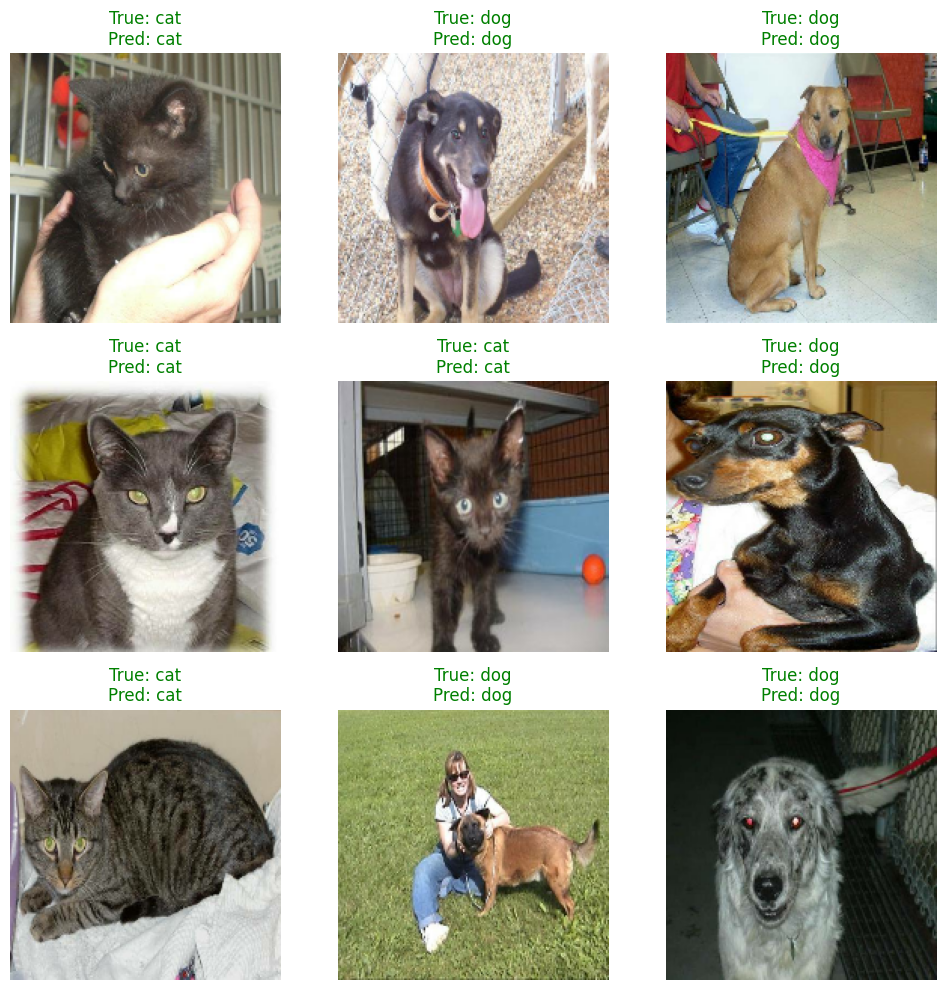

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    true_label = class_names[sample_labels[i]]
    pred_label = class_names[predicted_classes[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()

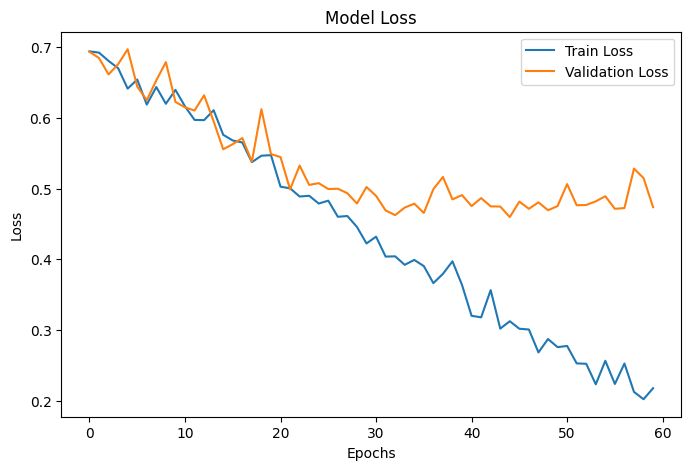

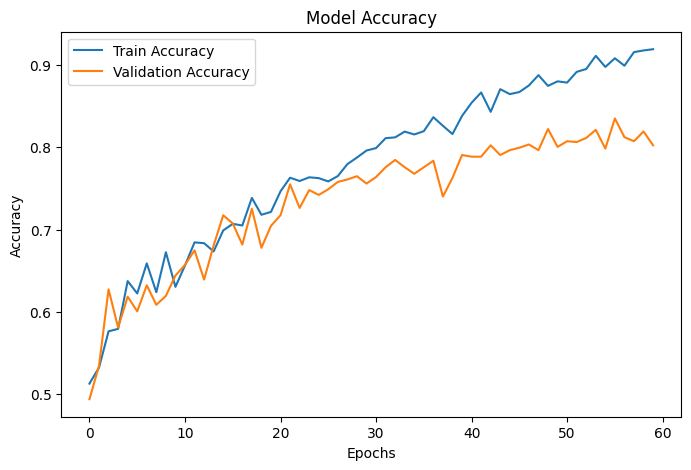

In [119]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy Graph
plt.figure(figsize=(8,5))
plt.plot(history.history['Accuracy'], label='Train Accuracy')
plt.plot(history.history['val_Accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [38]:
saved_model = keras.models.load_model('cnn.keras')

In [42]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Check if GPU is being used
print("Is GPU available:", tf.test.is_gpu_available())  # older versions
print("Is GPU available (recommended):", tf.config.list_physical_devices('GPU') != [])


Available GPUs: []
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available: False
Is GPU available (recommended): False


In [43]:
lspci | grep -i nvidia   # Linux
nvidia-smi               # Linux/Windows (if NVIDIA drivers installed)

SyntaxError: invalid syntax (2524176651.py, line 1)